In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [25]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [26]:
# shuffle up the words
import random
random.seed(2525)
random.shuffle(words)

In [27]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182451, 8]) torch.Size([182451])
torch.Size([22901, 8]) torch.Size([22901])
torch.Size([22794, 8]) torch.Size([22794])


In [28]:
for x,y in zip(Xtr[:8], Ytr[:8]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> t
.......t --> i
......ti --> m
.....tim --> o
....timo --> t
...timot --> h
..timoth --> e
.timothe --> e


In [29]:
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [51]:
class BatchNorm:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      elif x.ndim == 4:
        dim = (0, 1, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalization to unit variance
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [52]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [53]:
class Embedding: 

   def __init__(self, num_embeddings, embedding_dim):
      self.weight = torch.randn((num_embeddings, embedding_dim))
    
   def __call__(self, ix):
      self.out = self.weight[ix]
      return self.out
  
   def parameters(self):
      return [self.weight]

In [33]:
class Flatten:
   def __init__(self, n):
    self.n = n
    
   def __call__(self, x):
    b, t, c = x.shape
    x = x.view(b, t//self.n, c*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
   def parameters(self):
    return []

In [34]:
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [35]:
torch.manual_seed(2525)

In [58]:
n_embd = 36
n_hidden = 128

In [59]:
# Neural Network Initialisation

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Flatten(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Flatten(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size) # bias init
])

In [60]:
with torch.no_grad():
    model.layers[-1].weight *= 0.1
    

In [61]:
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

79975


In [62]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2730
  10000/ 200000: 2.0822
  20000/ 200000: 1.7430
  30000/ 200000: 1.6592
  40000/ 200000: 2.2052
  50000/ 200000: 1.6262
  60000/ 200000: 1.9136
  70000/ 200000: 2.2160
  80000/ 200000: 1.6845
  90000/ 200000: 2.0270
 100000/ 200000: 1.6267
 110000/ 200000: 2.0485
 120000/ 200000: 2.0458
 130000/ 200000: 1.4633
 140000/ 200000: 1.5399
 150000/ 200000: 1.4916
 160000/ 200000: 1.7245
 170000/ 200000: 1.6494
 180000/ 200000: 2.1062
 190000/ 200000: 1.8120


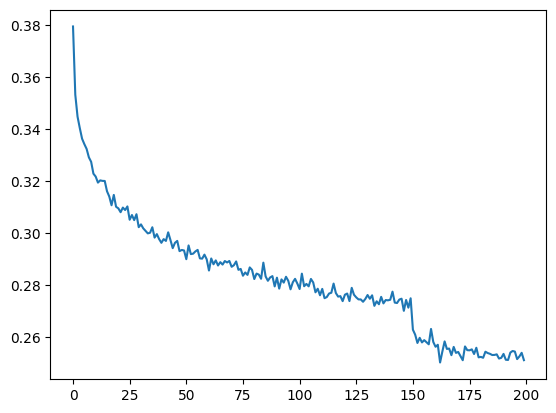

In [63]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [64]:
for layer in model.layers:
  layer.training = False

In [65]:
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7664211988449097
val 1.977854609489441


In [66]:
for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

aletai.
raye.
jaymion.
nevia.
saamaa.
kesley.
ellaely.
zalynn.
keneslie.
starlyn.
dakoto.
arihaa.
juleigh.
jahlia.
kadayah.
eili.
carling.
denra.
areia.
hila.
